In [35]:
import pandas as pd
import openpyxl
import os
import tslearn

file_path = os.path.join("..", "data", "final_transactions_with_clusters.csv")
kmpl_data = pd.read_csv(os.path.join("..", "data", "Final aggregated with KMPL and Imputed.csv"))
data = pd.read_csv(file_path)

In [36]:
data.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre', 'Month Name', 'Weekday Name', 'YearMonth',
       'AggClusterLabels', 'TransKmeansCluster'],
      dtype='object')

In [37]:
# Calculate the average transaction amount for each vehicle category
data['Average_Category_Amount'] = data.groupby(['Category'])['Transaction Amount'].transform('mean')

In [38]:
# Flag transaction amounts that are large for a category
data['Transaction_Amount_Flag'] = data['Transaction Amount'] > data['Average_Category_Amount'] * 1.5

In [39]:
# Check the value counts of the flag
data['Transaction_Amount_Flag'].value_counts()

Transaction_Amount_Flag
False    191454
True       5722
Name: count, dtype: int64

# Flag tranactions where the days between transactions are less than 2

In [40]:
# Convert 'Transaction Date' to datetime
data['Transaction Date'] = pd.to_datetime(data['Transaction Date'])

# Sort data by 'REG_NUM' and 'Transaction Date'
data.sort_values(by=['REG_NUM', 'Transaction Date'], inplace=True)

# Calculate the difference in days between transactions for each vehicle
data['Days_Between_Transactions'] = data.groupby('REG_NUM')['Transaction Date'].diff().dt.days

# Flag transactions that occur too frequently (less than 2 days apart) and the transaction amount is greater than the average transaction amount for that vehicle category
data['Transaction_Frequency_Flag'] = (data['Days_Between_Transactions'] < 2) & (data['Transaction Amount'] > data['Average_Category_Amount'])


In [41]:
# Check the value counts of the flag
data['Transaction_Frequency_Flag'].value_counts()

Transaction_Frequency_Flag
False    168123
True      29053
Name: count, dtype: int64

In [8]:
# Display 10 random rows where the flag is True
data[data['Transaction_Frequency_Flag']].sample(10)

,Transaction Date,REG_NUM,Merchant Name,Purchase Category,No. of Litres,Transaction Amount,Make,Model,Make and Model,Site,...,Estimated Price Per Litre,Month Name,Weekday Name,YearMonth,AggClusterLabels,TransKmeansCluster,Average_Category_Amount,Transaction_Amount_Flag,Days_Between_Transactions,Transaction_Frequency_Flag
163878,2021-12-01,GGA360EC,SHELL ULTRA CITY,FUEL,53.95,1066.05,ISUZU,DMAX 250,ISUZU DMAX 250,BUTTERWORTH,...,19.759963,December,Wednesday,2021-12,NaN,0.0,912.396075,False,1.0,True
80991,2021-08-30,GGA509EC,NORTH END SERVICE STATION,FUEL,60.81,1040.00,VOLKSWAGEN,CRAFTER 50,VOLKSWAGEN CRAFTER 50,GRAAF REINET,...,17.102450,August,Monday,2021-08,NaN,2.0,884.125518,False,0.0,True
29772,2021-05-17,GGP093EC,SKULPSPRUIT MOTORS,FUEL,52.65,902.05,NISSAN,NV 350,NISSAN NV 350,MOUNT FLERTCHER,...,17.132953,May,Monday,2021-05,NaN,2.0,824.389133,False,0.0,True
29337,2021-05-14,GGP064EC,ZAAYMAN S GARAGE,FUEL,83.49,1343.35,MERCEDES,SPRINTER,MERCEDES SPRINTER,Unknown,...,16.089951,May,Friday,2021-05,NaN,NaN,843.722324,True,1.0,True
145034,2021-11-03,GGA536EC,CALTEX CALA,FUEL,69.98,1360.57,VOLKSWAGEN,CRAFTER 35,VOLKSWAGEN CRAFTER 35,QUEENSTOWN,...,19.442269,November,Wednesday,2021-11,NaN,2.0,884.125518,True,0.0,True
118416,2021-10-07,GGA081EC,TOTAL OXFORD EAST LONDON,FUEL,56.80,1009.44,FORD,RANGER,FORD RANGER,TARKASTAD,...,17.771831,October,Thursday,2021-10,NaN,0.0,912.396075,False,1.0,True
180343,2021-12-23,GGZ986EC,MOUNT FRERE MOTORS,FUEL,43.00,844.70,ISUZU,KB 250,ISUZU KB 250,Unknown,...,19.644186,December,Thursday,2021-12,NaN,NaN,843.722324,False,2.0,True
79035,2021-08-21,GGA358EC,KEI MOTOR SERVICES,FUEL,62.72,1078.19,ISUZU,DMAX 250,ISUZU DMAX 250,BUTTERWORTH,...,17.190529,August,Saturday,2021-08,NaN,0.0,912.396075,False,1.0,True
165851,2021-12-29,GGA527EC,ENGEN TSOLO MOTORS,FUEL,64.38,1269.57,VOLKSWAGEN,CRAFTER 50,VOLKSWAGEN CRAFTER 50,MTHATHA,...,19.719944,December,Wednesday,2021-12,NaN,2.0,884.125518,False,2.0,True
164921,2021-11-29,GGA468EC,TOTAL OXFORD EAST LONDON,FUEL,65.70,1264.95,VOLKSWAGEN,CRAFTER 50,VOLKSWAGEN CRAFTER 50,EAST LONDON,...,19.253425,November,Monday,2021-11,NaN,2.0,884.125518,False,1.0,True


In [44]:
# Function to calculate if the difference exceeds the threshold for each transaction
def calculate_threshold(row):
    threshold = abs(row['Actual Fuel Price Inland'] - row['Actual Fuel Price'])
    return abs(row['Estimated Price Per Litre'] - row['Actual Fuel Price']) > threshold * 2


# Apply the function to each row
data['Fuel_Price_Flag'] = data.apply(calculate_threshold, axis=1)

In [46]:
# Check the value counts of the flag
data['Fuel_Price_Flag'].value_counts()

Fuel_Price_Flag
True     139131
False     58045
Name: count, dtype: int64

In [47]:
# Combine the different flags into a single column
data['Flag'] = data['Transaction_Amount_Flag'] | data['Transaction_Frequency_Flag'] | data['Fuel_Price_Flag']

# Add a "Reason" column based on the flags
data['Reason'] = 'Clear'

# Single flags
data.loc[data['Fuel_Price_Flag'] & ~data['Transaction_Frequency_Flag'] & ~data['Transaction_Amount_Flag'], 'Reason'] = 'PPL'
data.loc[data['Transaction_Frequency_Flag'] & ~data['Fuel_Price_Flag'] & ~data['Transaction_Amount_Flag'], 'Reason'] = 'Frequency'
data.loc[data['Transaction_Amount_Flag'] & ~data['Fuel_Price_Flag'] & ~data['Transaction_Frequency_Flag'], 'Reason'] = 'Amount'

# Intersections of two flags
data.loc[data['Fuel_Price_Flag'] & data['Transaction_Frequency_Flag'], 'Reason'] = 'PPL + Frequency'
data.loc[data['Fuel_Price_Flag'] & data['Transaction_Amount_Flag'], 'Reason'] = 'PPL + Amount'
data.loc[data['Transaction_Frequency_Flag'] & data['Transaction_Amount_Flag'], 'Reason'] = 'Frequency + Amount'

# Intersection of all three flags
data.loc[data['Fuel_Price_Flag'] & data['Transaction_Frequency_Flag'] & data['Transaction_Amount_Flag'], 'Reason'] = 'PPL + Frequency + Amount'

In [48]:
# Check the value counts of the flag
data['Reason'].value_counts()

Reason
PPL                         108517
Clear                        55274
PPL + Frequency              25199
PPL + Amount                  4077
Frequency                     2464
PPL + Frequency + Amount      1338
Amount                         255
Frequency + Amount              52
Name: count, dtype: int64

In [49]:
# Save the data to a new file
data.to_csv('../data/2021 Full Merch Coords and Fuel Price with Flags.csv', index=False)

In [50]:
kmpl_threshold = 5  # Set threshold for KMPL
kmpl_data['KMPL_Flag'] = kmpl_data['KMPL'] < kmpl_threshold

In [20]:
kmpl_data['KMPL_Flag'].value_counts()

KMPL_Flag
False    4169
True       91
Name: count, dtype: int64

In [21]:
# Save the KMPL flagged data to a new file
kmpl_data.to_csv('../data/2021 KMPL Flagged.csv', index=False)

# Plots of the flag vs non-flag transactions against different features

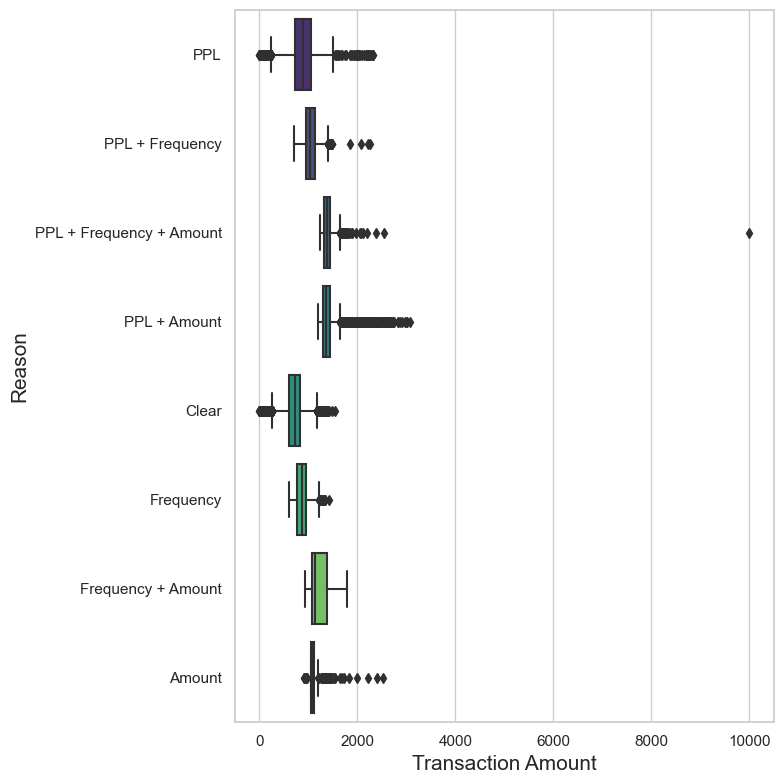

In [51]:
# Plot of flag against transaction amount
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.boxplot(x='Transaction Amount', y='Reason', data=data, ax=ax, palette="viridis")

# Setting labels and titles
ax.set_xlabel('Transaction Amount', fontsize=15) 
ax.set_ylabel('Reason', fontsize=15)  
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/heuristics/flag_amount.pdf', format='pdf', dpi=300)

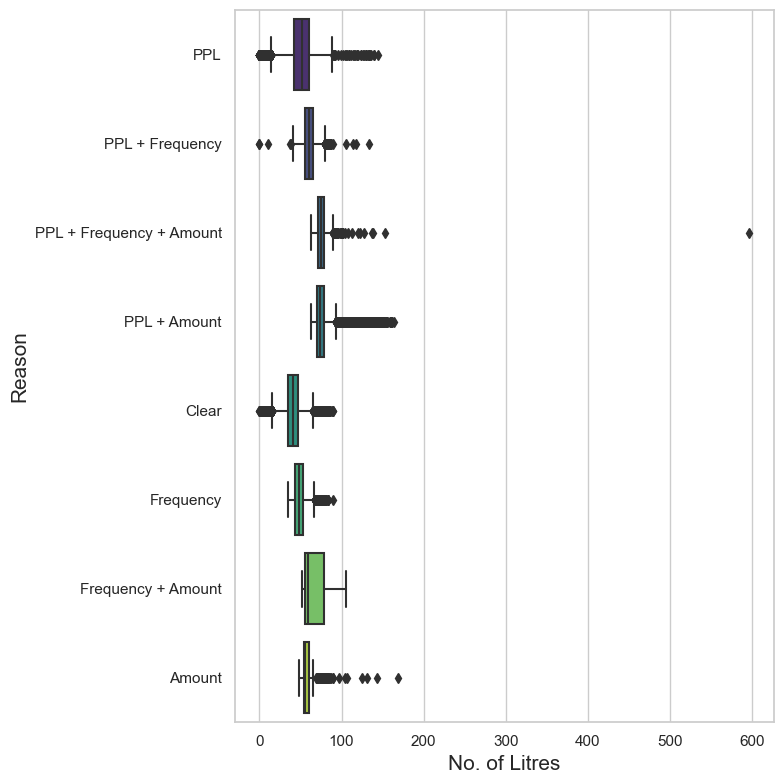

In [52]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.boxplot(x='No. of Litres', y='Reason', data=data, ax=ax, palette="viridis")

# Setting labels and titles
ax.set_xlabel('No. of Litres', fontsize=15) 
ax.set_ylabel('Reason', fontsize=15)  
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/heuristics/flag_litres.pdf', format='pdf', dpi=300)

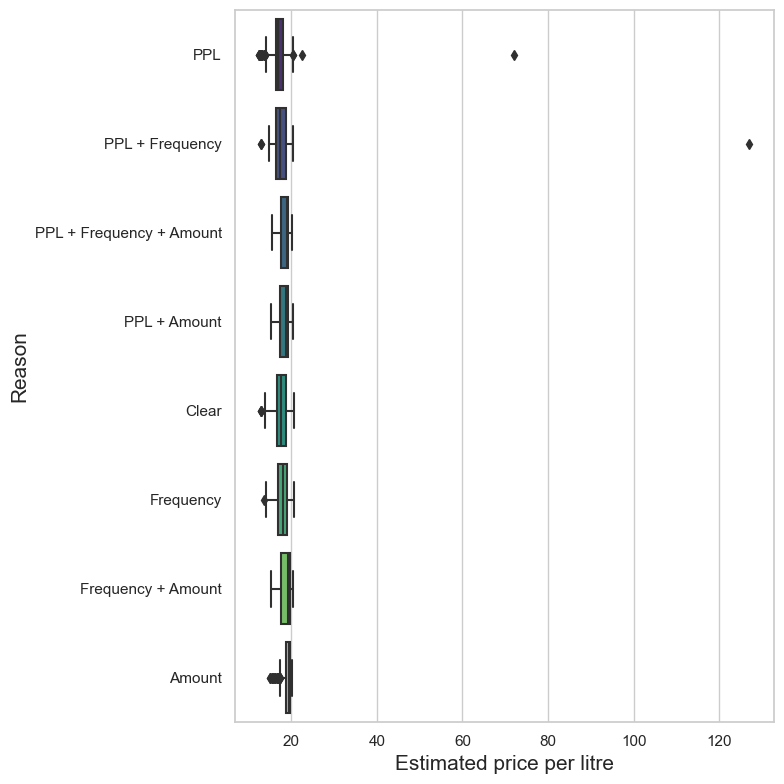

In [53]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.boxplot(x='Estimated Price Per Litre', y='Reason', data=data, ax=ax, palette="viridis")

# Setting labels and titles
ax.set_xlabel('Estimated price per litre', fontsize=15) 
ax.set_ylabel('Reason', fontsize=15)  
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/heuristics/flag_ppl.pdf', format='pdf', dpi=300)

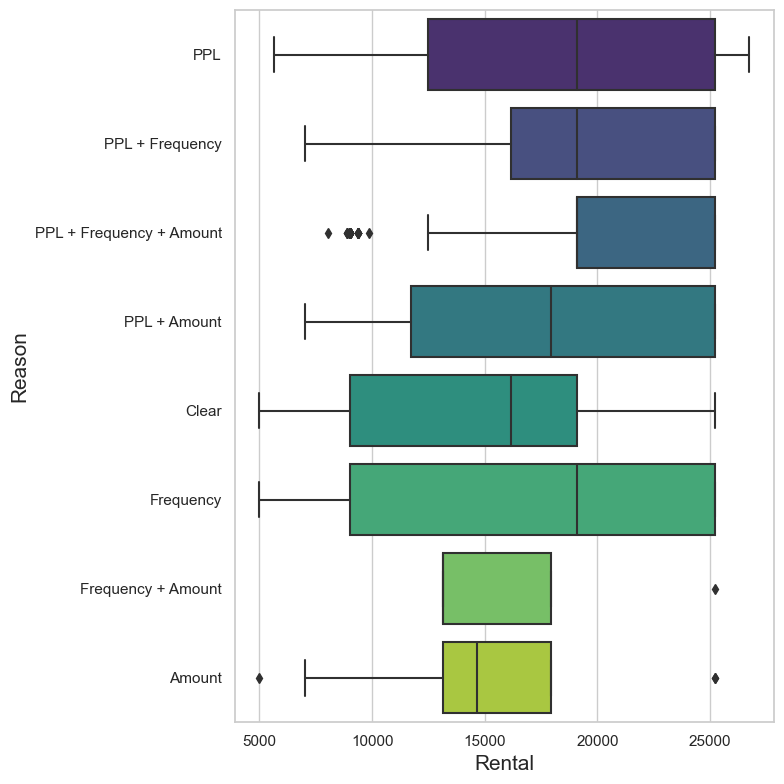

In [54]:
# Setting the aesthetic style of the plots
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 8)) 
sns.boxplot(x='Rental', y='Reason', data=data, ax=ax, palette="viridis")

# Setting labels and titles
ax.set_xlabel('Rental', fontsize=15) 
ax.set_ylabel('Reason', fontsize=15)  
plt.tight_layout()

# Save the plot as a PDF file with high resolution
plt.savefig('../final_plots/heuristics/flag_rental.pdf', format='pdf', dpi=300)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_categories(data, cluster_column, categorical_var, num_top_categories, legend_title, output_path='../final_plots/heuristics'):
    """
    Generates and saves a dynamic subplot grid showing the top categories for each cluster.
    """
    # Determine the top categories in each cluster
    top_categories = data.groupby([cluster_column, categorical_var]) \
                         .size() \
                         .reset_index(name='Counts') \
                         .sort_values(by=[cluster_column, 'Counts'], ascending=[True, False]) \
                         .groupby(cluster_column) \
                         .head(num_top_categories)

    # Number of clusters
    num_clusters = data[cluster_column].nunique()

    # Determine subplot grid dimensions
    if num_clusters <= 4:
        nrows, ncols = 2, 2
    else:  # For 5 or 6 clusters
        nrows, ncols = 4, 2

    plt.figure(figsize=(12, 8))  # Adjust figure size as needed

    # Sort the unique cluster labels to ensure proper order
    sorted_clusters = sorted(data[cluster_column].unique())

    # Create a subplot for each cluster
    for i, cluster in enumerate(sorted_clusters):
        plt.subplot(nrows, ncols, i + 1)
        cluster_data = top_categories[top_categories[cluster_column] == cluster]

        # Check if the cluster has data
        if not cluster_data.empty:
            sns.barplot(x=cluster_column, y='Counts', hue=categorical_var, data=cluster_data, palette="viridis")
            plt.xlabel('Reason', fontsize=15)
            plt.ylabel('Count', fontsize=15)
            plt.title(f'{cluster}')
            plt.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1))
        else:
            plt.text(0.5, 0.5, f'No data for Cluster {cluster}', fontsize=13, ha='center')

    plt.tight_layout()
    plt.savefig(f'{output_path}/top_{cluster_column}_{categorical_var}.pdf', format='pdf', dpi=300)

In [33]:
data.columns

Index(['Transaction Date', 'REG_NUM', 'Merchant Name', 'Purchase Category',
       'No. of Litres', 'Transaction Amount', 'Make', 'Model',
       'Make and Model', 'Site', 'District', 'Category', 'Rental',
       'Merchant Lat', 'Merchant Long', 'Site Lat', 'Site Long', 'Fuel Type',
       'Actual Fuel Price', 'Actual Fuel Price Inland',
       'Estimated Price Per Litre', 'Month Name', 'Weekday Name', 'YearMonth',
       'AggClusterLabels', 'TransKmeansCluster', 'Average_Category_Amount',
       'Transaction_Amount_Flag', 'Days_Between_Transactions',
       'Transaction_Frequency_Flag', 'Fuel_Price_Flag', 'Flag', 'Reason'],
      dtype='object')

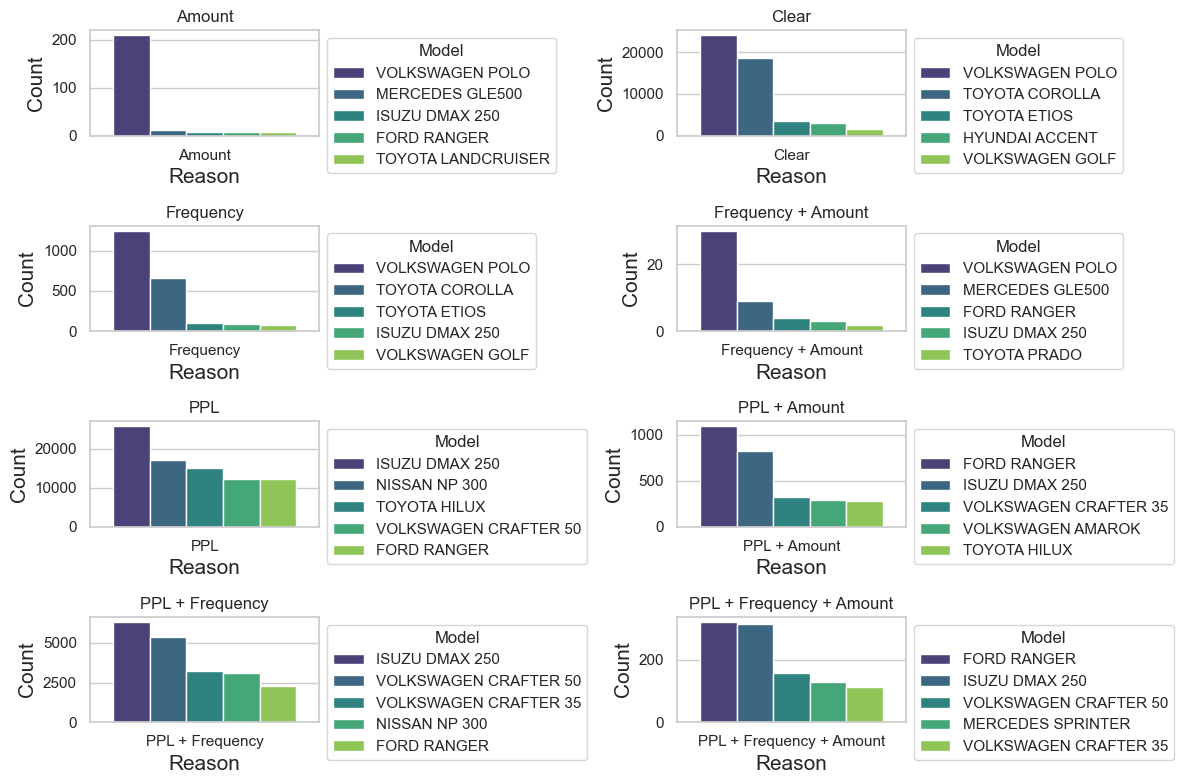

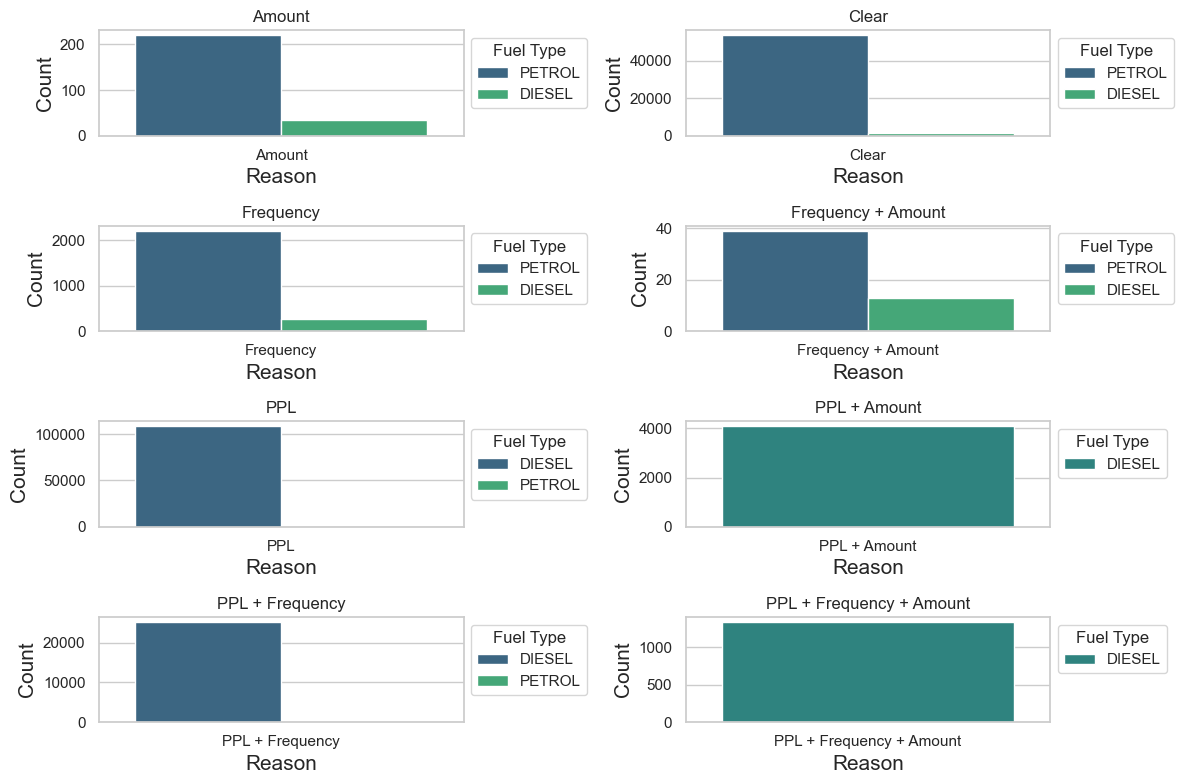

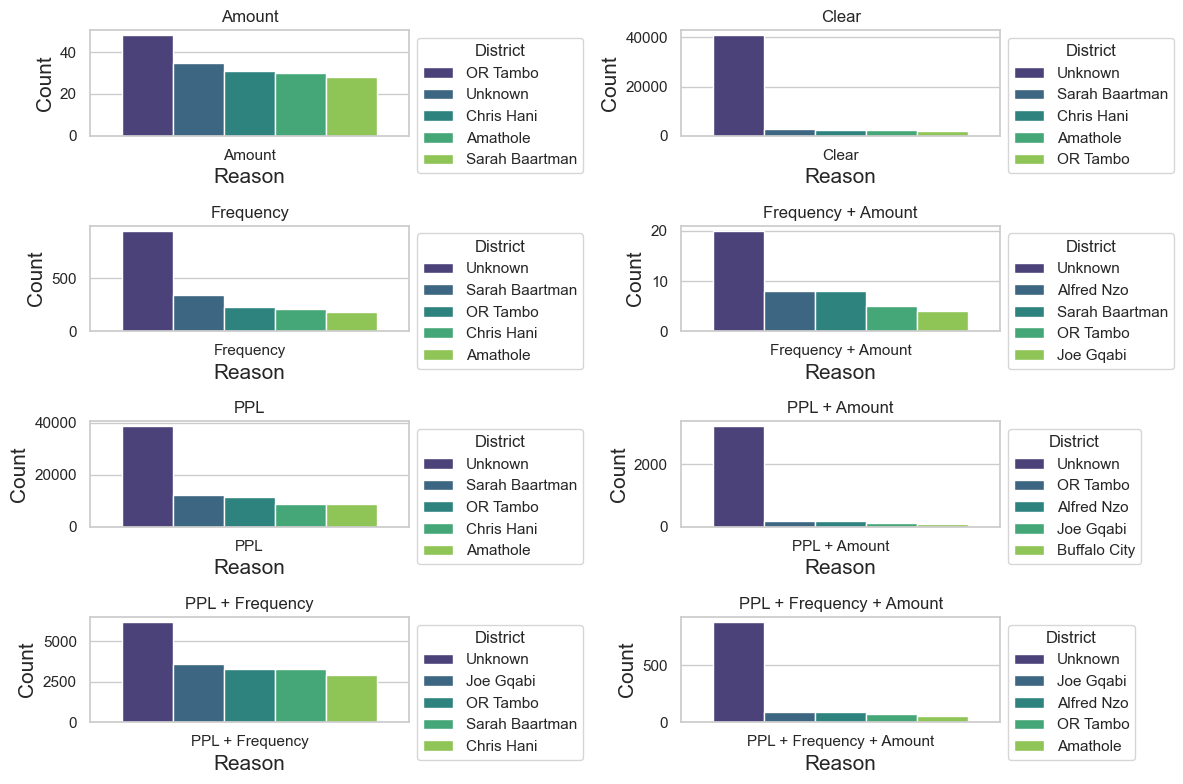

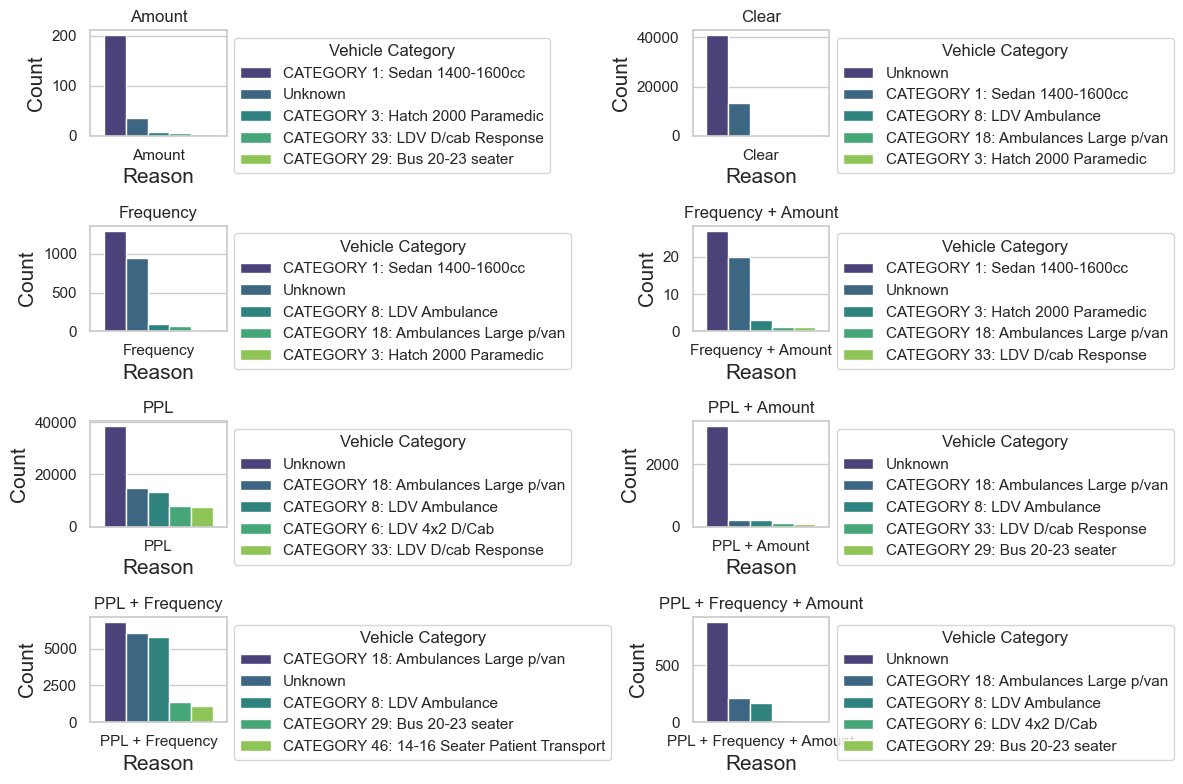

In [56]:
plot_top_categories(data, 'Reason', 'Make and Model', 5, legend_title='Model')
plot_top_categories(data, 'Reason', 'Fuel Type', 5, legend_title='Fuel Type')
plot_top_categories(data, 'Reason', 'District', 5, legend_title='District')
plot_top_categories(data, 'Reason', 'Category', 5, legend_title='Vehicle Category')